In [1]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import itertools
import joblib
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler,RobustScaler,Normalizer,MaxAbsScaler
from sklearn.model_selection import train_test_split
from airbnbCABATransformer import AirbnbCABATransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score,mean_squared_log_error
import xgboost as xgb
import lightgbm as lgb
import catboost as ctb
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from hyperopt import hp, Trials, tpe
from HPOpt import HPOpt

In [2]:
#Cargamos el dataset limpio 
data = pd.read_csv('data/listings.csv')
data1 = pd.read_csv('data/listings_1.csv')
data2 = pd.read_csv('data/listings_2.csv')
data3 = pd.read_csv('data/listings_3.csv')
data = pd.concat([data, data1,data2,data3])
#data = data.drop_duplicates(subset=data.columns.difference(['price']))
data = data.drop_duplicates()
data = data.reset_index()

In [3]:
dataclean = AirbnbCABATransformer().transform(data)
dataclean.head()

This pattern has match groups. To actually get the groups, use str.extract.


,host_identity_verified,accommodates,bathrooms,bedrooms,price,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,neighbourhood_group,...,Villa Santa Rita,Villa Soldati,Villa Urquiza,Apartment,House,Entire home/apt,Private room,Shared room,bathroomtype_private,bathroomtype_shared
0,1.0,2.0,1,1,9823,3,1125.0,30,4.77,0.0,...,0,0,0,1,0,1,0,0,1,0
1,1.0,2.0,1,1,5687,2,730.0,24,4.63,0.0,...,0,0,0,1,0,1,0,0,1,0
2,1.0,2.0,1,1,3728,7,1125.0,98,4.77,0.0,...,0,0,0,1,0,1,0,0,1,0
3,1.0,4.0,2,1,6514,14,1125.0,10,4.67,0.0,...,0,0,0,1,0,1,0,0,1,0
4,1.0,2.0,1,1,3584,5,730.0,29,4.79,0.0,...,0,0,0,1,0,1,0,0,1,0


In [4]:
dataclean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47883 entries, 0 to 49826
Data columns (total 74 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   host_identity_verified  47883 non-null  float64
 1   accommodates            47883 non-null  float64
 2   bathrooms               47883 non-null  int32  
 3   bedrooms                47883 non-null  int32  
 4   price                   47883 non-null  int64  
 5   minimum_nights          47883 non-null  int64  
 6   maximum_nights          47883 non-null  float64
 7   number_of_reviews       47883 non-null  int64  
 8   review_scores_rating    47883 non-null  float64
 9   neighbourhood_group     47883 non-null  float64
 10  air_conditioning        47883 non-null  int32  
 11  pool                    47883 non-null  int32  
 12  parking                 47883 non-null  int32  
 13  tv                      47883 non-null  int32  
 14  internet                47883 non-null

In [5]:
#Genero mi variable X
X=dataclean.drop(['price'],axis=1)

#Genero la variable y
y = dataclean['price']

#Creamos las muestras
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 10,shuffle=True)

folds=StratifiedKFold(n_splits=5,shuffle=True, random_state=41)

---
### Funciones extras

In [6]:
def getscores(model,X_test,y_test,X_train,y_train,model_name):
    y_pred_test = model.predict(X_test)
    
    mse_test = np.round(mean_squared_error(y_test, y_pred_test),5)
    rmse_test = np.round(np.sqrt(mse_test),5)
    mae_test = np.round(mean_absolute_error(y_test, y_pred_test),5)
    r2_test =  np.round(r2_score(y_test, y_pred_test),5)
    
    y_pred_train = model.predict(X_train)

    mse_train = np.round(mean_squared_error(y_train, y_pred_train),5)
    rmse_train = np.round(np.sqrt(mse_train),5)
    mae_train = np.round(mean_absolute_error(y_train, y_pred_train),5)
    r2_train =  np.round(r2_score(y_train, y_pred_train),5)
    
    data = [mse_test,rmse_test,mae_test,r2_test, mse_train,rmse_train,mae_train,r2_train]
    
    return {model_name:data}
    
def plot_train_test(y_test, y_pred_test, y_train, y_pred_train, model_name):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))

    axes[0].plot([i for i in range(len(y_test))],y_test, 'ro', label="Test Values")
    axes[0].plot([i for i in range(len(y_test))],y_pred_test, 'bo', label="Predicted "+model_name+" values")
    axes[0].legend()

    axes[1].plot([i for i in range(len(y_train))],y_train, 'ro', label="Train values")
    axes[1].plot([i for i in range(len(y_train))],y_pred_train, 'bo', label="Predicted "+model_name+" values")
    axes[1].legend()

    fig.text(0.5, 0.09, 'Item', ha='center')
    fig.text(0.08, 0.5, 'Precio por noche', va='center', rotation='vertical')
    plt.show()

---
## Algoritmos
### Árboles

In [7]:
# Random Forest
rndfo_reg_params = {
    'bootstrap':         hp.choice('bootstrap', ["True", "False"]),
    'max_depth':         hp.choice("max_depth", np.arange(1, 11, 1, dtype=int)),
    'max_features':      hp.choice('max_features', ['auto', 'sqrt','log2']),
    'min_samples_leaf':  hp.choice('min_samples_leaf', [0.1,1,2,4]),
    'min_samples_split': hp.choice('min_samples_split', [0.1,0.5,0.8,0.9,2,4,6]),
    'n_estimators':      hp.randint('n_estimators', 100, 1000),
    'random_state' : 50,
    'verbose': False,
    'n_jobs' :-1,
}

rndfo_para = dict()
rndfo_para['reg_params'] = rndfo_reg_params
rndfo_para['loss_func' ] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))

# XGB parameters
xgb_reg_params = {
    'learning_rate':    hp.choice('learning_rate',    [0.001,0.01,0.1,0.2,0.3,0.5,1]),
    'max_depth':        hp.choice('max_depth',        np.arange(1, 10, 1, dtype=int)),
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 8, 1, dtype=int)),
    'colsample_bytree': hp.choice('colsample_bytree', [0.1,0.3,0.5, 0.8, 0.1]),
    'subsample':        hp.uniform('subsample', 0, 1),
    'n_estimators':     hp.choice('n_estimators', [100,200,300,400,500,600,700,800,900,1000]),
    'random_state':     50,
    'eval_metric': 'rmse',
}
xgb_fit_params = {
    'early_stopping_rounds': 10,
    'verbose': False
}
xgb_para = dict()
xgb_para['reg_params'] = xgb_reg_params
xgb_para['fit_params'] = xgb_fit_params
xgb_para['loss_func' ] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))


# LightGBM parameters
lgb_reg_params = {
    'learning_rate':    hp.choice('learning_rate',    [0.001,0.01,0.1,0.2,0.3,0.5,1]),
    'max_depth':        hp.choice('max_depth',        np.arange(1, 10, 1, dtype=int)),
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 8, 1, dtype=int)),
    'colsample_bytree': hp.choice('colsample_bytree', [0.1,0.3,0.5, 0.8, 0.1]),
    'subsample':        hp.uniform('subsample', 0.1, 1),
    'n_estimators':     hp.choice('n_estimators', [100,200,300,400,500,600,700,800,900,1000]),
    'random_state':     50,
}

lgb_fit_params = {
    'eval_metric':      'l2',
    'early_stopping_rounds': 10,
    'verbose': False,
}
lgb_para = dict()
lgb_para['reg_params'] = lgb_reg_params
lgb_para['fit_params'] = lgb_fit_params
lgb_para['loss_func' ] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))

# CatBoost parameters
ctb_reg_params = {
    'random_state':   50,
    'learning_rate':  hp.uniform('learning_rate', 0.1, 0.5),
    'iterations':     hp.randint('iterations',100,1000),
    'l2_leaf_reg':    hp.randint('l2_leaf_reg',1,10),
    'depth':          hp.randint('depth',1,10),
    'bootstrap_type': hp.choice('bootstrap_type', ['Bayesian', 'Bernoulli']),
    'eval_metric':    'RMSE',
}

ctb_fit_params = {
    'early_stopping_rounds': 10,
    'verbose': False,
}

ctb_para = dict()
ctb_para['reg_params'] = ctb_reg_params
ctb_para['fit_params'] = ctb_fit_params
ctb_para['loss_func' ] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))

In [8]:
obj = HPOpt(X_train, X_test, y_train, y_test)

trials = [Trials(),Trials(),Trials(),Trials()]

xgb_opt = obj.process(fn_name='xgb_reg', space=xgb_para, trials=trials[0], algo=tpe.suggest, max_evals=100)
lgb_opt = obj.process(fn_name='lgb_reg', space=lgb_para, trials=trials[1], algo=tpe.suggest, max_evals=100)
ctb_opt = obj.process(fn_name='ctb_reg', space=ctb_para, trials=trials[2], algo=tpe.suggest, max_evals=100)
rndfor_opt = obj.process(fn_name='rndfor_reg', space=rndfo_para, trials=trials[3], algo=tpe.suggest, max_evals=100)

  1%|▍                                                | 1/100 [00:00<01:09,  1.42trial/s, best loss: 3573.236396221782]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



  2%|▉                                               | 2/100 [00:26<25:04, 15.36s/trial, best loss: 3184.9007851929046]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



  3%|█▍                                              | 3/100 [00:28<15:24,  9.53s/trial, best loss: 3184.9007851929046]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



  4%|█▉                                              | 4/100 [00:32<11:39,  7.29s/trial, best loss: 3184.9007851929046]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



  6%|██▉                                             | 6/100 [00:34<05:27,  3.48s/trial, best loss: 3184.9007851929046]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



  7%|███▎                                            | 7/100 [00:36<04:32,  2.93s/trial, best loss: 3184.9007851929046]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



  8%|███▊                                            | 8/100 [00:39<04:49,  3.15s/trial, best loss: 3184.9007851929046]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



  9%|████▎                                           | 9/100 [00:41<04:04,  2.68s/trial, best loss: 3184.9007851929046]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 10%|████▋                                          | 10/100 [00:42<03:20,  2.23s/trial, best loss: 3184.9007851929046]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 11%|█████▏                                         | 11/100 [00:46<04:10,  2.81s/trial, best loss: 3184.9007851929046]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 12%|█████▋                                         | 12/100 [00:47<03:17,  2.24s/trial, best loss: 3184.9007851929046]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 13%|██████                                         | 13/100 [00:48<02:44,  1.89s/trial, best loss: 3184.9007851929046]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 14%|██████▌                                        | 14/100 [00:49<02:17,  1.59s/trial, best loss: 3184.9007851929046]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 15%|███████                                        | 15/100 [00:50<01:43,  1.22s/trial, best loss: 3184.9007851929046]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 16%|███████▌                                       | 16/100 [00:52<02:00,  1.44s/trial, best loss: 3184.9007851929046]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 17%|███████▉                                       | 17/100 [00:58<03:54,  2.83s/trial, best loss: 3184.9007851929046]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 18%|████████▍                                      | 18/100 [01:01<04:02,  2.95s/trial, best loss: 3184.9007851929046]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 19%|████████▉                                      | 19/100 [01:05<04:29,  3.33s/trial, best loss: 3005.1616705683296]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 20%|█████████▍                                     | 20/100 [01:08<04:28,  3.36s/trial, best loss: 3005.1616705683296]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 21%|█████████▊                                     | 21/100 [01:12<04:26,  3.37s/trial, best loss: 3005.1616705683296]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 22%|██████████▎                                    | 22/100 [01:19<05:42,  4.40s/trial, best loss: 3005.1616705683296]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 23%|██████████▊                                    | 23/100 [01:25<06:12,  4.83s/trial, best loss: 3005.1616705683296]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 24%|███████████▎                                   | 24/100 [01:30<06:13,  4.92s/trial, best loss: 3005.1616705683296]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 25%|███████████▊                                   | 25/100 [01:35<06:29,  5.19s/trial, best loss: 3005.1616705683296]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 26%|████████████▏                                  | 26/100 [01:42<06:54,  5.60s/trial, best loss: 3005.1616705683296]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 27%|████████████▉                                   | 27/100 [01:55<09:21,  7.70s/trial, best loss: 2952.819797411631]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 28%|█████████████▍                                  | 28/100 [02:05<10:01,  8.35s/trial, best loss: 2952.819797411631]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 29%|█████████████▉                                  | 29/100 [02:17<11:16,  9.53s/trial, best loss: 2952.819797411631]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 30%|██████████████▍                                 | 30/100 [02:18<08:17,  7.11s/trial, best loss: 2952.819797411631]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 31%|██████████████▉                                 | 31/100 [02:31<09:57,  8.66s/trial, best loss: 2951.318815974751]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 32%|███████████████                                | 32/100 [02:49<13:06, 11.57s/trial, best loss: 2922.5339388465754]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 33%|███████████████▌                               | 33/100 [03:04<14:15, 12.76s/trial, best loss: 2922.5339388465754]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 34%|███████████████▉                               | 34/100 [03:23<15:59, 14.54s/trial, best loss: 2916.7344069798205]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 35%|████████████████▍                              | 35/100 [03:31<13:42, 12.65s/trial, best loss: 2916.7344069798205]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 36%|████████████████▉                              | 36/100 [03:36<10:56, 10.25s/trial, best loss: 2916.7344069798205]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 37%|█████████████████▍                             | 37/100 [03:37<07:46,  7.40s/trial, best loss: 2916.7344069798205]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 38%|█████████████████▊                             | 38/100 [03:47<08:30,  8.23s/trial, best loss: 2916.7344069798205]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 39%|██████████████████▎                            | 39/100 [03:58<09:22,  9.23s/trial, best loss: 2916.7344069798205]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 40%|██████████████████▊                            | 40/100 [04:06<08:42,  8.70s/trial, best loss: 2916.7344069798205]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 41%|███████████████████▎                           | 41/100 [04:11<07:24,  7.54s/trial, best loss: 2916.7344069798205]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 42%|███████████████████▋                           | 42/100 [04:23<08:40,  8.97s/trial, best loss: 2916.7344069798205]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 43%|████████████████████▏                          | 43/100 [04:36<09:45, 10.28s/trial, best loss: 2916.7344069798205]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 44%|████████████████████▋                          | 44/100 [04:37<06:50,  7.33s/trial, best loss: 2916.7344069798205]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 45%|█████████████████████▏                         | 45/100 [04:42<06:12,  6.77s/trial, best loss: 2916.7344069798205]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 46%|█████████████████████▌                         | 46/100 [04:58<08:35,  9.55s/trial, best loss: 2916.7344069798205]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 47%|██████████████████████                         | 47/100 [05:00<06:22,  7.22s/trial, best loss: 2916.7344069798205]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 48%|██████████████████████▌                        | 48/100 [05:06<05:57,  6.88s/trial, best loss: 2916.7344069798205]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 49%|███████████████████████                        | 49/100 [05:09<04:44,  5.58s/trial, best loss: 2916.7344069798205]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 50%|███████████████████████▌                       | 50/100 [05:11<03:44,  4.50s/trial, best loss: 2916.7344069798205]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 51%|███████████████████████▉                       | 51/100 [05:11<02:41,  3.29s/trial, best loss: 2916.7344069798205]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 52%|████████████████████████▍                      | 52/100 [05:14<02:27,  3.08s/trial, best loss: 2916.7344069798205]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 53%|████████████████████████▉                      | 53/100 [05:15<01:53,  2.42s/trial, best loss: 2916.7344069798205]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 54%|█████████████████████████▍                     | 54/100 [05:15<01:27,  1.91s/trial, best loss: 2916.7344069798205]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 55%|█████████████████████████▊                     | 55/100 [05:19<01:43,  2.30s/trial, best loss: 2916.7344069798205]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 56%|██████████████████████████▎                    | 56/100 [05:27<03:05,  4.21s/trial, best loss: 2916.7344069798205]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 57%|██████████████████████████▊                    | 57/100 [05:31<02:50,  3.96s/trial, best loss: 2916.7344069798205]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 58%|███████████████████████████▎                   | 58/100 [05:32<02:10,  3.10s/trial, best loss: 2916.7344069798205]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 59%|███████████████████████████▋                   | 59/100 [05:33<01:46,  2.60s/trial, best loss: 2916.7344069798205]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 60%|████████████████████████████▏                  | 60/100 [05:41<02:42,  4.07s/trial, best loss: 2916.7344069798205]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 61%|████████████████████████████▋                  | 61/100 [05:47<03:02,  4.69s/trial, best loss: 2916.7344069798205]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 62%|█████████████████████████████▏                 | 62/100 [05:47<02:12,  3.48s/trial, best loss: 2916.7344069798205]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 63%|█████████████████████████████▌                 | 63/100 [05:57<03:20,  5.42s/trial, best loss: 2916.7344069798205]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 64%|██████████████████████████████                 | 64/100 [06:02<03:07,  5.20s/trial, best loss: 2916.7344069798205]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 65%|██████████████████████████████▌                | 65/100 [06:20<05:18,  9.11s/trial, best loss: 2916.7344069798205]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 66%|███████████████████████████████▋                | 66/100 [06:39<06:48, 12.01s/trial, best loss: 2915.920196407532]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 67%|████████████████████████████████▏               | 67/100 [06:56<07:21, 13.39s/trial, best loss: 2915.920196407532]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 68%|████████████████████████████████▋               | 68/100 [07:13<07:41, 14.42s/trial, best loss: 2915.920196407532]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 69%|█████████████████████████████████               | 69/100 [07:23<06:49, 13.20s/trial, best loss: 2915.920196407532]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 70%|█████████████████████████████████▌              | 70/100 [07:38<06:53, 13.79s/trial, best loss: 2915.920196407532]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 71%|██████████████████████████████████              | 71/100 [07:45<05:44, 11.87s/trial, best loss: 2915.920196407532]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 72%|██████████████████████████████████▌             | 72/100 [07:47<04:04,  8.73s/trial, best loss: 2915.920196407532]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 73%|███████████████████████████████████             | 73/100 [07:49<03:01,  6.71s/trial, best loss: 2915.920196407532]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 74%|███████████████████████████████████▌            | 74/100 [07:52<02:25,  5.61s/trial, best loss: 2915.920196407532]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 75%|███████████████████████████████████▎           | 75/100 [08:08<03:36,  8.65s/trial, best loss: 2914.8166452761266]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 76%|███████████████████████████████████▋           | 76/100 [08:15<03:20,  8.37s/trial, best loss: 2914.8166452761266]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 77%|████████████████████████████████████▏          | 77/100 [08:24<03:11,  8.31s/trial, best loss: 2914.8166452761266]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 78%|████████████████████████████████████▋          | 78/100 [08:24<02:11,  5.98s/trial, best loss: 2914.8166452761266]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 79%|█████████████████████████████████████▏         | 79/100 [08:38<02:55,  8.38s/trial, best loss: 2914.8166452761266]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 80%|█████████████████████████████████████▌         | 80/100 [08:53<03:25, 10.30s/trial, best loss: 2914.8166452761266]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 81%|██████████████████████████████████████         | 81/100 [09:03<03:13, 10.17s/trial, best loss: 2914.8166452761266]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 82%|██████████████████████████████████████▌        | 82/100 [09:05<02:18,  7.72s/trial, best loss: 2914.8166452761266]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 83%|███████████████████████████████████████        | 83/100 [09:11<02:04,  7.32s/trial, best loss: 2914.8166452761266]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 84%|███████████████████████████████████████▍       | 84/100 [09:12<01:28,  5.52s/trial, best loss: 2914.8166452761266]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 85%|███████████████████████████████████████▉       | 85/100 [09:14<01:05,  4.38s/trial, best loss: 2914.8166452761266]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 86%|████████████████████████████████████████▍      | 86/100 [09:20<01:07,  4.82s/trial, best loss: 2914.8166452761266]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 87%|████████████████████████████████████████▉      | 87/100 [09:34<01:40,  7.70s/trial, best loss: 2914.8166452761266]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 88%|█████████████████████████████████████████▎     | 88/100 [09:35<01:06,  5.58s/trial, best loss: 2914.8166452761266]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 89%|█████████████████████████████████████████▊     | 89/100 [09:38<00:52,  4.77s/trial, best loss: 2914.8166452761266]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 90%|██████████████████████████████████████████▎    | 90/100 [09:41<00:43,  4.33s/trial, best loss: 2914.8166452761266]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 91%|██████████████████████████████████████████▊    | 91/100 [09:44<00:35,  3.91s/trial, best loss: 2914.8166452761266]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 92%|███████████████████████████████████████████▏   | 92/100 [09:49<00:33,  4.24s/trial, best loss: 2914.8166452761266]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 93%|███████████████████████████████████████████▋   | 93/100 [09:51<00:24,  3.55s/trial, best loss: 2914.8166452761266]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 94%|████████████████████████████████████████████▏  | 94/100 [09:57<00:25,  4.29s/trial, best loss: 2914.8166452761266]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 95%|████████████████████████████████████████████▋  | 95/100 [09:58<00:16,  3.39s/trial, best loss: 2914.8166452761266]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 96%|█████████████████████████████████████████████  | 96/100 [10:07<00:20,  5.01s/trial, best loss: 2914.8166452761266]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 97%|█████████████████████████████████████████████▌ | 97/100 [10:15<00:17,  5.72s/trial, best loss: 2914.8166452761266]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 98%|██████████████████████████████████████████████ | 98/100 [10:15<00:08,  4.22s/trial, best loss: 2914.8166452761266]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 99%|██████████████████████████████████████████████▌| 99/100 [10:18<00:03,  3.74s/trial, best loss: 2914.8166452761266]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



  0%|                                                                          | 0/100 [00:00<?, ?trial/s, best loss=?]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



100%|███████████████████████████████████████████████| 100/100 [03:41<00:00,  2.22s/trial, best loss: 3343.660762345734]


In [9]:
# Entreno los modelos de árboles en base a sus parámetros
xgb_model=xgb.XGBRegressor(**trials[0].results[np.argmin([result['loss'] for result in trials[0].results])]['params'])
xgb_model.fit(X_train,y_train)

lgb_model = lgb.LGBMRegressor(**trials[1].results[np.argmin([result['loss'] for result in trials[1].results])]['params'])
lgb_model.fit(X_train,y_train)

ctb_model = ctb.CatBoostRegressor(**trials[2].results[np.argmin([result['loss'] for result in trials[2].results])]['params'])
ctb_model.fit(X_train,y_train)

rndfo_model = RandomForestRegressor(**trials[3].results[np.argmin([result['loss'] for result in trials[3].results])]['params'])
rndfo_model.fit(X_train,y_train)

0:	learn: 4334.3332341	total: 20ms	remaining: 15.6s
1:	learn: 4111.1464465	total: 31.6ms	remaining: 12.3s
2:	learn: 3943.6322715	total: 44.4ms	remaining: 11.5s
3:	learn: 3828.4806343	total: 66.1ms	remaining: 12.9s
4:	learn: 3736.9753244	total: 76.8ms	remaining: 11.9s
5:	learn: 3667.8621291	total: 88.1ms	remaining: 11.4s
6:	learn: 3621.3076211	total: 99ms	remaining: 11s
7:	learn: 3581.6702364	total: 111ms	remaining: 10.8s
8:	learn: 3537.6597238	total: 123ms	remaining: 10.6s
9:	learn: 3507.5180007	total: 134ms	remaining: 10.3s
10:	learn: 3483.3949380	total: 146ms	remaining: 10.2s
11:	learn: 3465.7843306	total: 174ms	remaining: 11.2s
12:	learn: 3447.0513231	total: 185ms	remaining: 11s
13:	learn: 3431.7854538	total: 196ms	remaining: 10.8s
14:	learn: 3419.5683389	total: 213ms	remaining: 10.9s
15:	learn: 3404.0943658	total: 234ms	remaining: 11.2s
16:	learn: 3393.3570043	total: 252ms	remaining: 11.4s
17:	learn: 3386.1674989	total: 263ms	remaining: 11.2s
18:	learn: 3375.3417299	total: 274ms	re

163:	learn: 2698.7012896	total: 2.42s	remaining: 9.15s
164:	learn: 2694.8454022	total: 2.44s	remaining: 9.16s
165:	learn: 2691.7243729	total: 2.46s	remaining: 9.13s
166:	learn: 2687.3352621	total: 2.48s	remaining: 9.13s
167:	learn: 2683.8156592	total: 2.49s	remaining: 9.12s
168:	learn: 2681.8636351	total: 2.51s	remaining: 9.11s
169:	learn: 2679.3934554	total: 2.52s	remaining: 9.08s
170:	learn: 2675.0318028	total: 2.53s	remaining: 9.06s
171:	learn: 2671.4003865	total: 2.55s	remaining: 9.06s
172:	learn: 2666.0079903	total: 2.56s	remaining: 9.03s
173:	learn: 2664.6855482	total: 2.57s	remaining: 9.01s
174:	learn: 2662.7518957	total: 2.6s	remaining: 9.02s
175:	learn: 2658.6580387	total: 2.61s	remaining: 9s
176:	learn: 2654.7451556	total: 2.62s	remaining: 8.97s
177:	learn: 2650.8976943	total: 2.63s	remaining: 8.94s
178:	learn: 2647.9537778	total: 2.64s	remaining: 8.91s
179:	learn: 2645.7903126	total: 2.65s	remaining: 8.89s
180:	learn: 2642.4954956	total: 2.7s	remaining: 8.97s
181:	learn: 264

324:	learn: 2307.1329260	total: 4.87s	remaining: 6.87s
325:	learn: 2305.5892406	total: 4.89s	remaining: 6.86s
326:	learn: 2304.7098883	total: 4.9s	remaining: 6.83s
327:	learn: 2303.3198598	total: 4.91s	remaining: 6.81s
328:	learn: 2301.9555615	total: 4.93s	remaining: 6.81s
329:	learn: 2299.1153047	total: 4.95s	remaining: 6.79s
330:	learn: 2296.7914920	total: 4.97s	remaining: 6.78s
331:	learn: 2295.5999410	total: 4.98s	remaining: 6.77s
332:	learn: 2293.8327365	total: 5s	remaining: 6.75s
333:	learn: 2292.7194190	total: 5.01s	remaining: 6.73s
334:	learn: 2291.7207725	total: 5.03s	remaining: 6.72s
335:	learn: 2289.3471230	total: 5.04s	remaining: 6.71s
336:	learn: 2288.0161925	total: 5.05s	remaining: 6.69s
337:	learn: 2286.6445054	total: 5.07s	remaining: 6.67s
338:	learn: 2285.1369846	total: 5.08s	remaining: 6.65s
339:	learn: 2282.6301735	total: 5.11s	remaining: 6.65s
340:	learn: 2280.3805465	total: 5.12s	remaining: 6.63s
341:	learn: 2279.2068277	total: 5.14s	remaining: 6.62s
342:	learn: 22

479:	learn: 2066.8970801	total: 7.09s	remaining: 4.48s
480:	learn: 2066.1588567	total: 7.12s	remaining: 4.47s
481:	learn: 2064.7062560	total: 7.13s	remaining: 4.45s
482:	learn: 2064.1187450	total: 7.16s	remaining: 4.45s
483:	learn: 2062.2158843	total: 7.17s	remaining: 4.43s
484:	learn: 2061.3230730	total: 7.19s	remaining: 4.42s
485:	learn: 2059.9630652	total: 7.2s	remaining: 4.4s
486:	learn: 2058.0097325	total: 7.21s	remaining: 4.38s
487:	learn: 2056.9018197	total: 7.22s	remaining: 4.37s
488:	learn: 2055.6359082	total: 7.24s	remaining: 4.35s
489:	learn: 2054.6373978	total: 7.25s	remaining: 4.34s
490:	learn: 2053.5858697	total: 7.27s	remaining: 4.32s
491:	learn: 2053.2192066	total: 7.28s	remaining: 4.31s
492:	learn: 2051.8322583	total: 7.3s	remaining: 4.29s
493:	learn: 2051.1388137	total: 7.31s	remaining: 4.28s
494:	learn: 2049.7693180	total: 7.32s	remaining: 4.26s
495:	learn: 2048.9900206	total: 7.34s	remaining: 4.24s
496:	learn: 2047.1407984	total: 7.35s	remaining: 4.23s
497:	learn: 2

629:	learn: 1913.9689760	total: 9.29s	remaining: 2.26s
630:	learn: 1913.0062321	total: 9.3s	remaining: 2.24s
631:	learn: 1912.4776693	total: 9.33s	remaining: 2.23s
632:	learn: 1911.8318787	total: 9.34s	remaining: 2.21s
633:	learn: 1910.6213188	total: 9.35s	remaining: 2.2s
634:	learn: 1909.6772116	total: 9.36s	remaining: 2.18s
635:	learn: 1908.8800035	total: 9.39s	remaining: 2.17s
636:	learn: 1908.2567229	total: 9.4s	remaining: 2.15s
637:	learn: 1906.4196472	total: 9.41s	remaining: 2.14s
638:	learn: 1905.1557374	total: 9.43s	remaining: 2.12s
639:	learn: 1903.9107021	total: 9.44s	remaining: 2.11s
640:	learn: 1903.5532968	total: 9.45s	remaining: 2.09s
641:	learn: 1902.3897748	total: 9.46s	remaining: 2.08s
642:	learn: 1901.2165591	total: 9.48s	remaining: 2.06s
643:	learn: 1899.6330779	total: 9.49s	remaining: 2.05s
644:	learn: 1897.6285149	total: 9.5s	remaining: 2.03s
645:	learn: 1896.4116389	total: 9.51s	remaining: 2.02s
646:	learn: 1895.4286334	total: 9.53s	remaining: 2s
647:	learn: 1894.

RandomForestRegressor(bootstrap='False', max_depth=10, min_samples_leaf=2,
                      min_samples_split=4, n_estimators=918, n_jobs=-1,
                      random_state=50, verbose=False)

### Visualización previa de los alfas

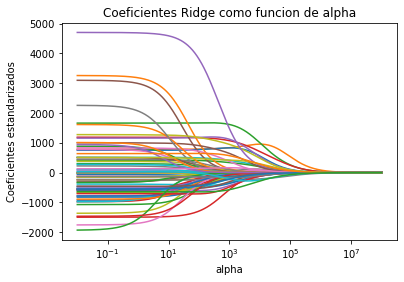

In [10]:
#Análisis previo de los alpha
alphas_ridge = np.logspace(-2, 8,400)
ridge = linear_model.Ridge(max_iter=10000)
coefs = []

for a in alphas_ridge:
    ridge.set_params(alpha=a)
    ridge.fit(X_train, y_train)
    coefs.append(ridge.coef_)

ax = plt.gca()

ax.plot(alphas_ridge, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Coeficientes estandarizados')
plt.title('Coeficientes Ridge como funcion de alpha');

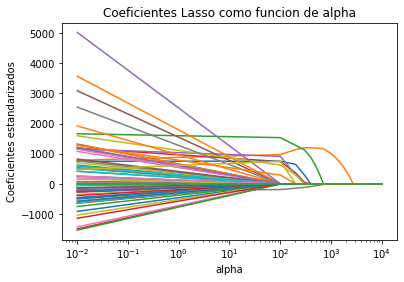

In [11]:
#Análisis previo de los alpha
alphas_lasso = np.linspace(0.01,10000,100)
lasso = linear_model.Lasso(max_iter = 10000, normalize = False)
coefs = []

for a in alphas_lasso:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)

ax = plt.gca()
ax.plot(alphas_lasso, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Coeficientes estandarizados')
plt.title('Coeficientes Lasso como funcion de alpha');

### GridSearch para otros algoritmos de regresión

In [70]:
#Inicializo pipelines de regresión
pipe_linr = Pipeline([('scl', None),
                    ('linr', linear_model.LinearRegression())])
pipe_ridge = Pipeline([('scl', None),
                    ('ridge', linear_model.Ridge(random_state=50))])
pipe_lasso = Pipeline([('scl', None),
                    ('lasso',linear_model.Lasso(random_state=50))])

# Parámetros para diversos pipelines
linr_param_grid = [{ 
                    'scl':[StandardScaler(), MinMaxScaler(), Normalizer(), MaxAbsScaler(), None],
                    }]

ridge_param_grid = [{ 
                    'scl':[StandardScaler(), MinMaxScaler(), Normalizer(), MaxAbsScaler(), None],
                    'ridge__alpha': np.logspace(-2, 8,400)
                    }]

lasso_param_grid = [{ 
                    'scl':[StandardScaler(), MinMaxScaler(), Normalizer(), MaxAbsScaler(), None],
                    'lasso__alpha': np.linspace(0.01,10000,100),
                    'lasso__max_iter': [10000],
                    }]

linr_grid_search = GridSearchCV(estimator=pipe_linr,
                        param_grid = linr_param_grid,
                        cv=folds,
                        verbose=1,
                        n_jobs=-1,
                        scoring='neg_root_mean_squared_error')

ridge_grid_search = GridSearchCV(estimator=pipe_ridge,
                        param_grid = ridge_param_grid,
                        cv=folds,
                        verbose=1,
                        n_jobs=-1,
                        scoring='neg_root_mean_squared_error')

lasso_grid_search = GridSearchCV(estimator=pipe_lasso,
                        param_grid = lasso_param_grid,
                        cv=folds,
                        verbose=1,
                        n_jobs=-1,
                        scoring='neg_root_mean_squared_error')


grids = [linr_grid_search, ridge_grid_search, lasso_grid_search]
for pipe in grids:
    pipe.fit(X_train,y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


The least populated class in y has only 1 members, which is less than n_splits=5.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    3.3s finished
The least populated class in y has only 1 members, which is less than n_splits=5.


Fitting 5 folds for each of 2000 candidates, totalling 10000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   27.8s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:   43.8s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 6026 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 7176 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 8426 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 9776 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 10000 out of 1000

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


The least populated class in y has only 1 members, which is less than n_splits=5.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:  3.0min finished


---
## Análisis

In [71]:
models = [
        {
        'name':'Linear Regression',
        'model': grids[0].best_estimator_
        },
        {
        'name':'Ridge',
        'model': grids[1].best_estimator_
        },
        {
        'name':'Lasso',
        'model': grids[2].best_estimator_
        },
        {
        'name':'XGBoost',
        'model': xgb_model
        },
        {
        'name':'LGBoost',
        'model': lgb_model
        },
        {
        'name':'CatBoost',
        'model': ctb_model
        },
        {
        'name':'Random Forest',
        'model': rndfo_model
        },
    ]

list=[]

for key in models:
    list.append(pd.DataFrame(getscores(key["model"],X_test,y_test,X_train,y_train,key["name"]),index=['MSE Test','RMSE Test','MAE Test','R2 Test','MSE Train','RMSE Train','MAE Train','R2 Train']))
    
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.concat(list,axis=1)

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


,Linear Regression,Ridge,Lasso,XGBoost,LGBoost,CatBoost,Random Forest
MSE Test,13769595.90230,13776007.86449,13769506.59745,8496838.02160,9470608.87299,8502777.99761,11180067.29365
RMSE Test,3710.74061,3711.60449,3710.72858,2914.93362,3077.43544,2915.95233,3343.66076
MAE Test,2436.95288,2436.82012,2436.90986,1877.83615,2033.53047,1885.34823,2195.74287
R2 Test,0.36126,0.36096,0.36126,0.60585,0.56068,0.60558,0.48138
MSE Train,13513213.97944,13517282.94570,13513219.53882,3156255.61039,4901104.64093,3164746.88876,9643813.49748
RMSE Train,3676.03237,3676.58577,3676.03313,1776.58538,2213.84386,1778.97355,3105.44900
MAE Train,2447.72857,2446.77238,2447.68053,1150.71372,1454.55763,1197.13322,2079.19760
R2 Train,0.37406,0.37387,0.37406,0.85380,0.77298,0.85341,0.55329


#### Gráficos LR

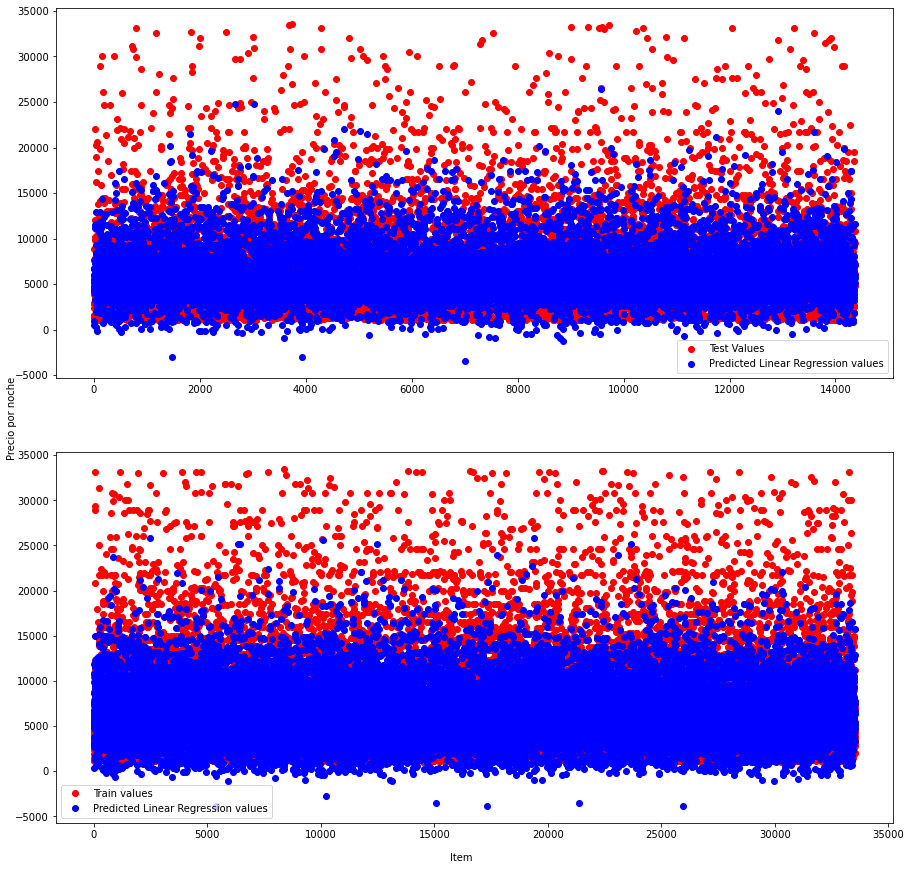

In [14]:
#Linear Regression
y_test_prediction = models[0]["model"].predict(X_test)
y_train_prediction = models[0]["model"].predict(X_train)
plot_train_test(y_test,y_test_prediction,y_train,y_train_prediction,models[0]["name"])

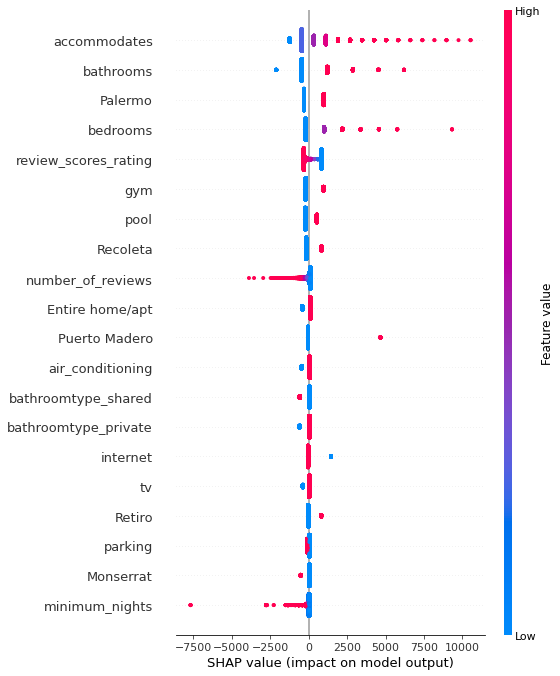

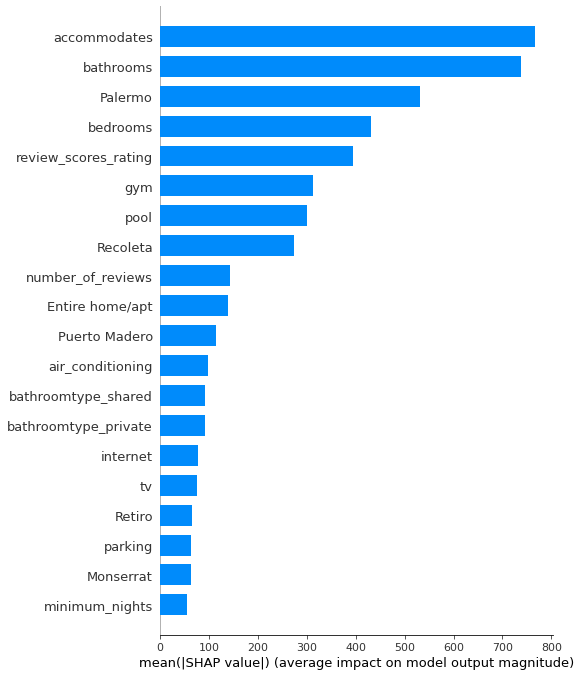

In [78]:
explainer = shap.LinearExplainer(linear_model.LinearRegression().fit(X_train,y_train),X_test)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)
shap.summary_plot(shap_values, X_test, plot_type='bar')

#### Gráficos Ridge

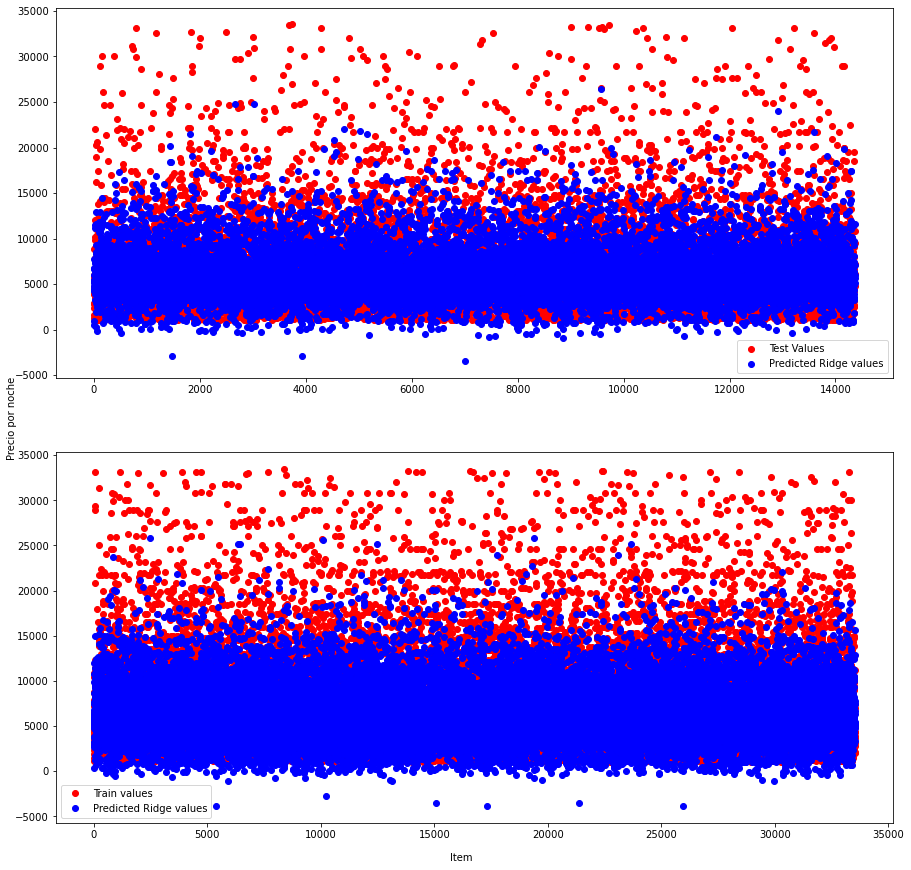

In [15]:
#Ridge
y_test_prediction = models[1]["model"].predict(X_test)
y_train_prediction = models[1]["model"].predict(X_train)
plot_train_test(y_test,y_test_prediction,y_train,y_train_prediction,models[1]["name"])

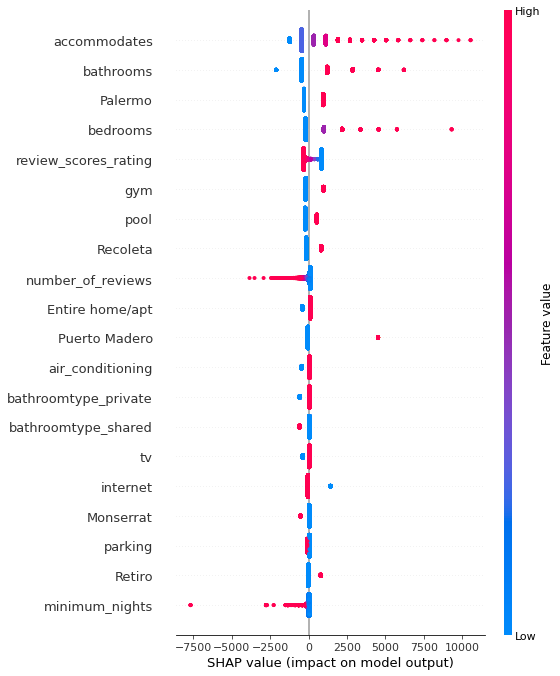

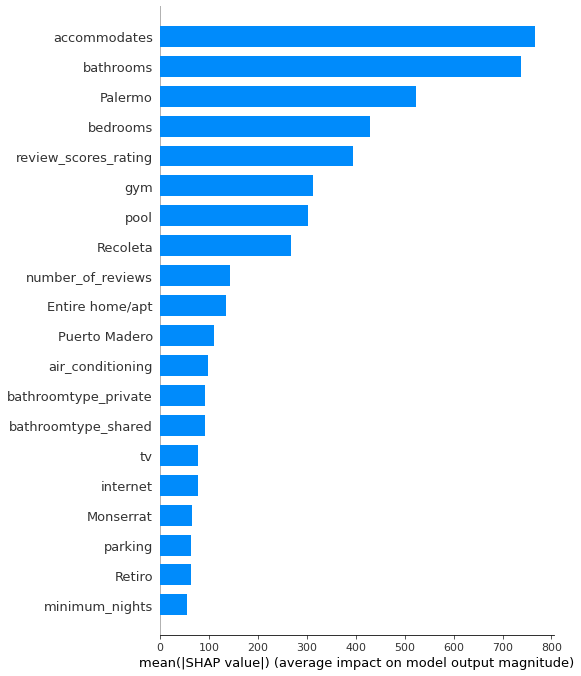

In [76]:
explainer = shap.LinearExplainer(linear_model.Ridge(alpha=models[1]["model"].steps[1][1].alpha,random_state=models[1]["model"].steps[1][1].random_state,).fit(X_train,y_train),X_test)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)
shap.summary_plot(shap_values, X_test, plot_type='bar')

#### Gráficos Lasso

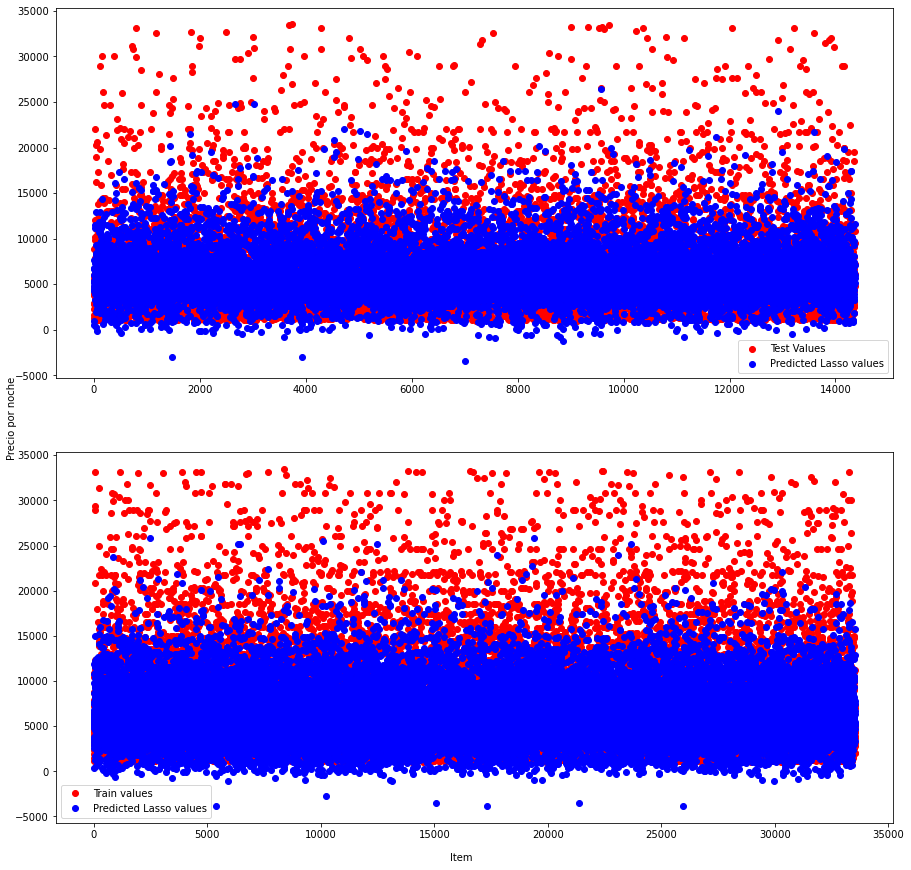

In [16]:
#Lasso
y_test_prediction = models[2]["model"].predict(X_test)
y_train_prediction = models[2]["model"].predict(X_train)
plot_train_test(y_test,y_test_prediction,y_train,y_train_prediction,models[2]["name"])

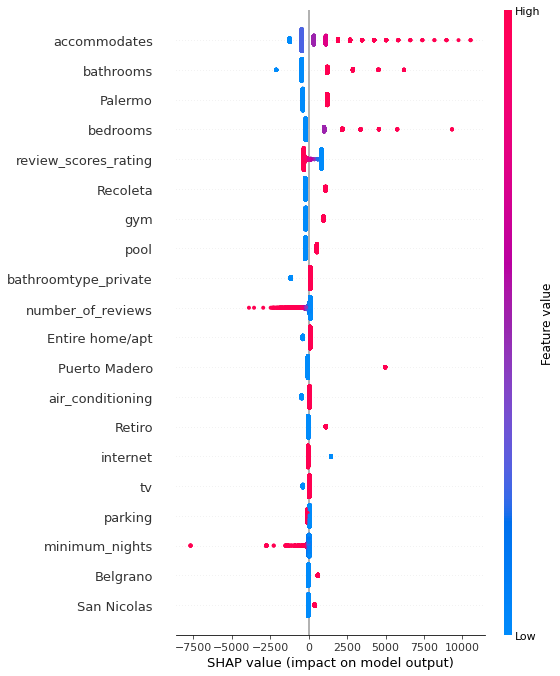

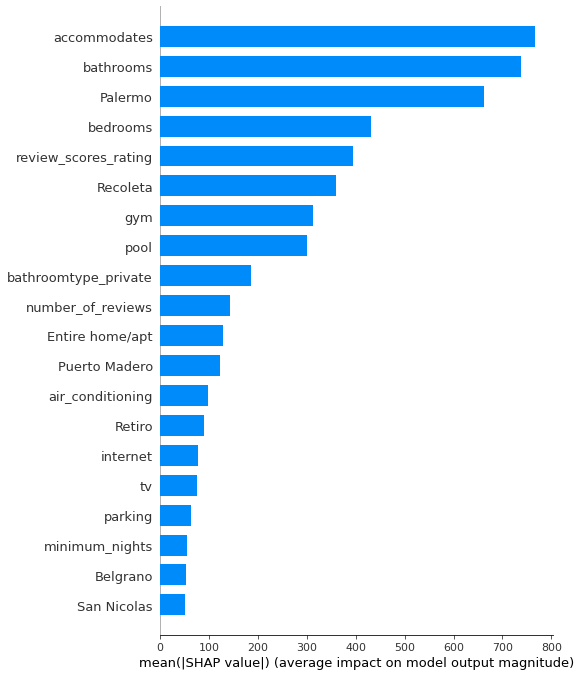

In [74]:
explainer = shap.LinearExplainer(linear_model.Lasso(alpha=models[2]["model"].steps[1][1].alpha,max_iter=models[2]["model"].steps[1][1].max_iter,random_state=models[2]["model"].steps[1][1].random_state,).fit(X_train,y_train),X_test)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)
shap.summary_plot(shap_values, X_test, plot_type='bar')

#### Gráficos XGBoost

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


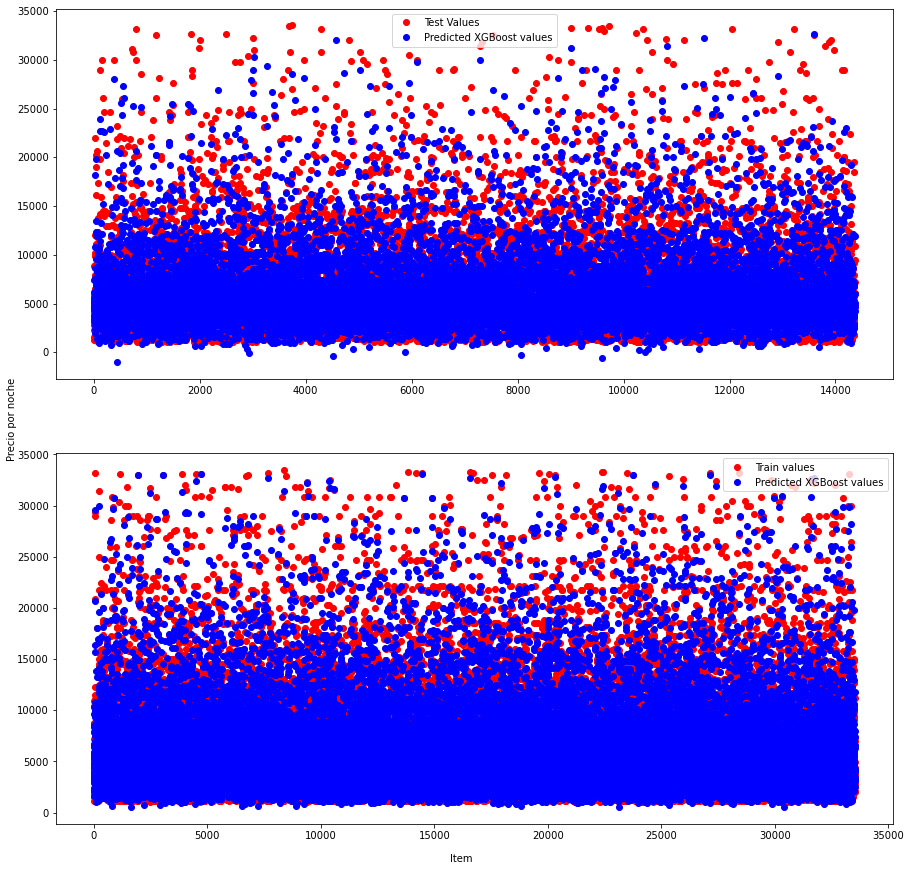

In [17]:
#XGBoost
y_test_prediction = models[3]["model"].predict(X_test)
y_train_prediction = models[3]["model"].predict(X_train)
plot_train_test(y_test,y_test_prediction,y_train,y_train_prediction,models[3]["name"])

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


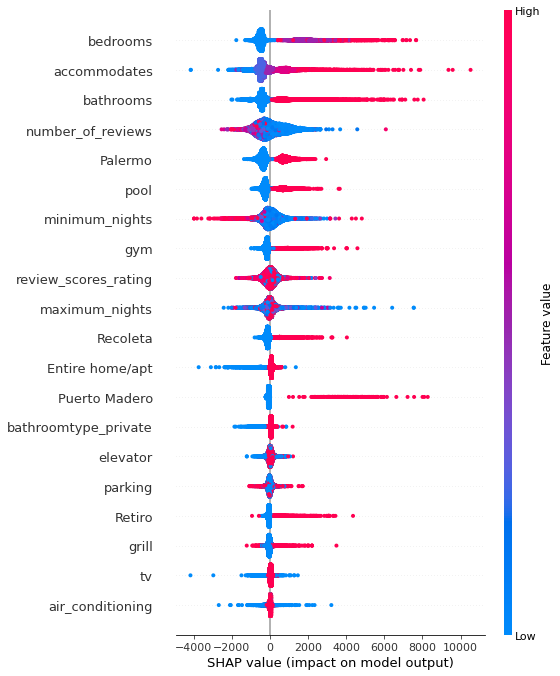

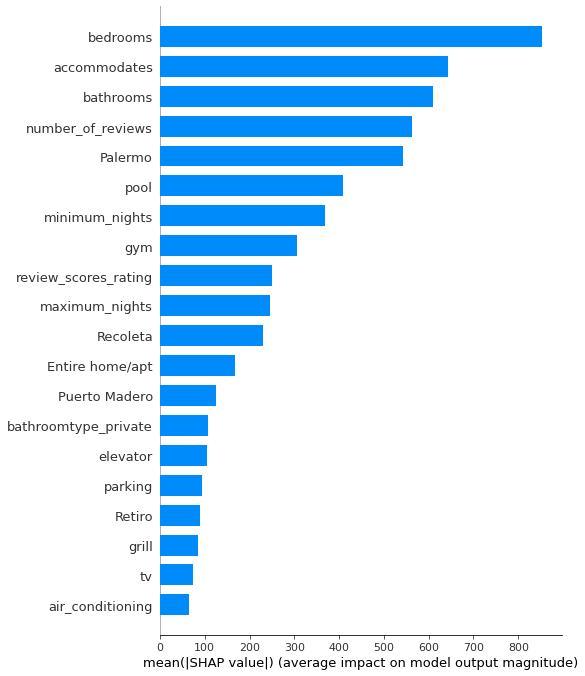

In [18]:
explainer = shap.TreeExplainer(models[3]["model"])
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)
shap.summary_plot(shap_values, X_test, plot_type='bar')

#### Gráficos LGBoost

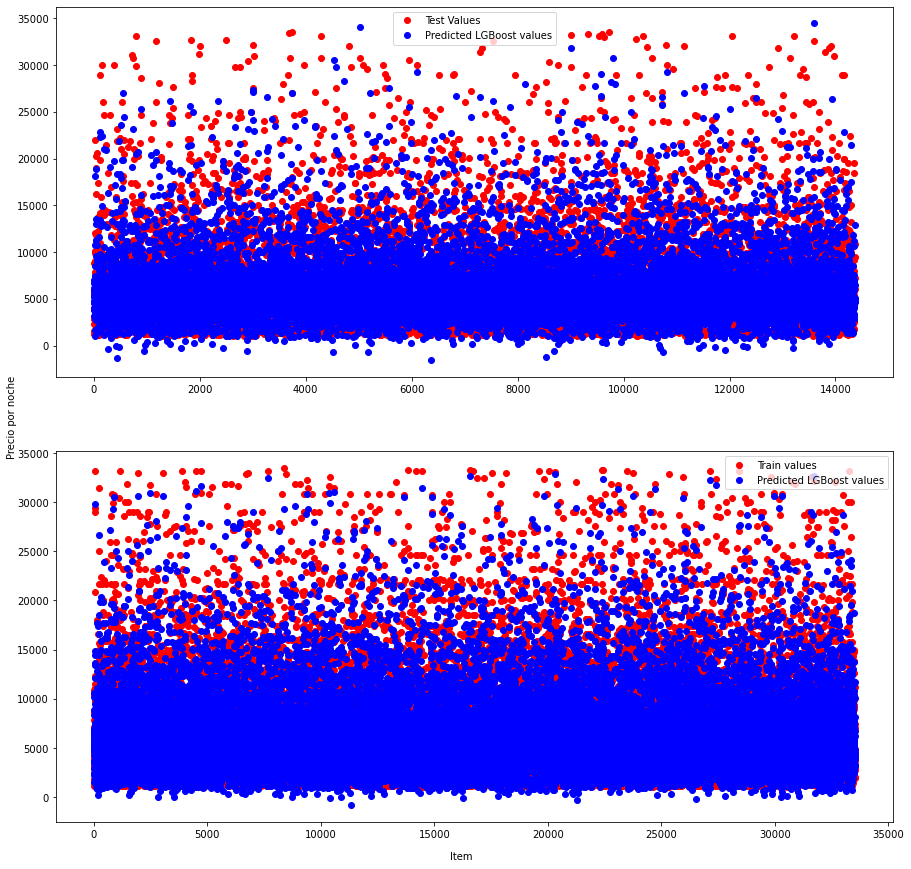

In [19]:
#LGBoost
y_test_prediction = models[4]["model"].predict(X_test)
y_train_prediction = models[4]["model"].predict(X_train)
plot_train_test(y_test,y_test_prediction,y_train,y_train_prediction,models[4]["name"])

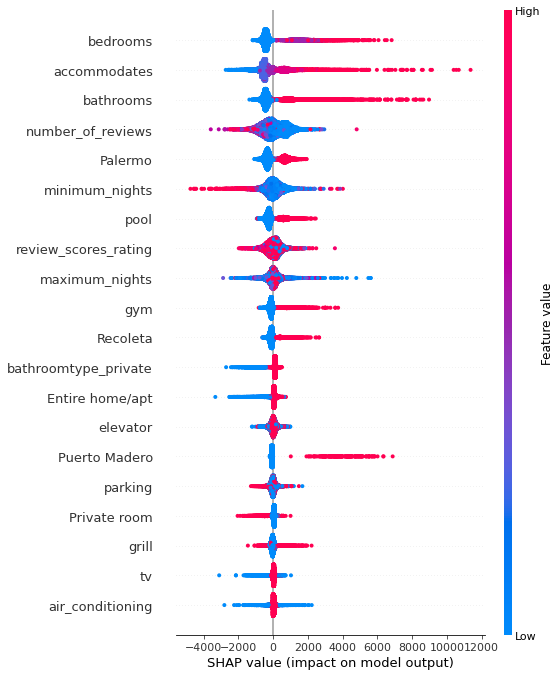

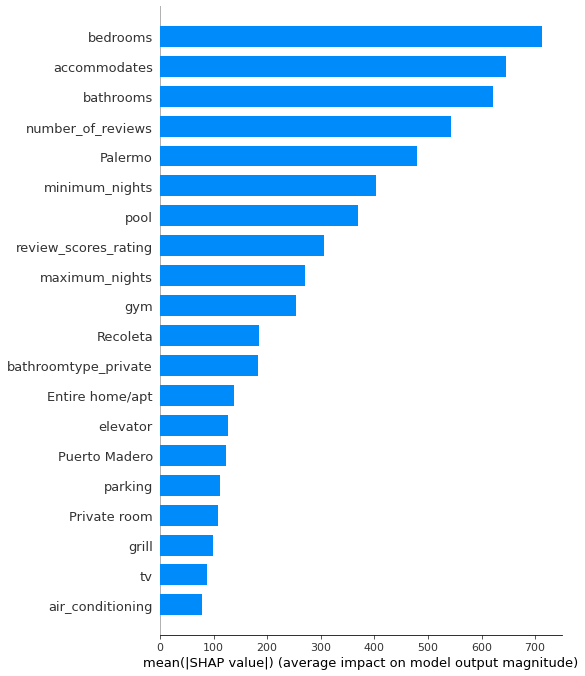

In [20]:
explainer = shap.TreeExplainer(models[4]["model"])
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)
shap.summary_plot(shap_values, X_test, plot_type='bar')

#### Gráficos CatBoost

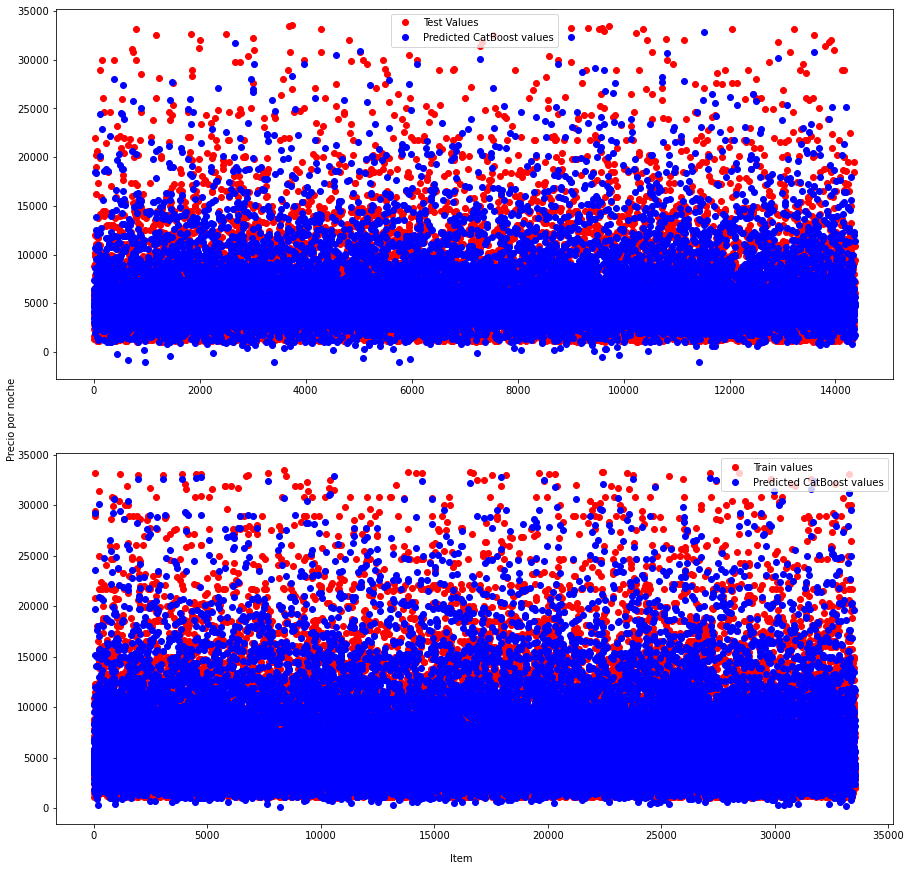

In [21]:
#LGBoost
y_test_prediction = models[5]["model"].predict(X_test)
y_train_prediction = models[5]["model"].predict(X_train)
plot_train_test(y_test,y_test_prediction,y_train,y_train_prediction,models[5]["name"])

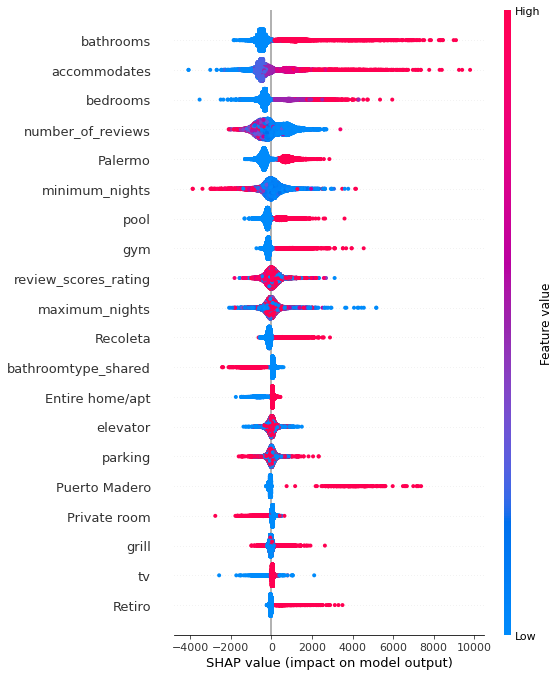

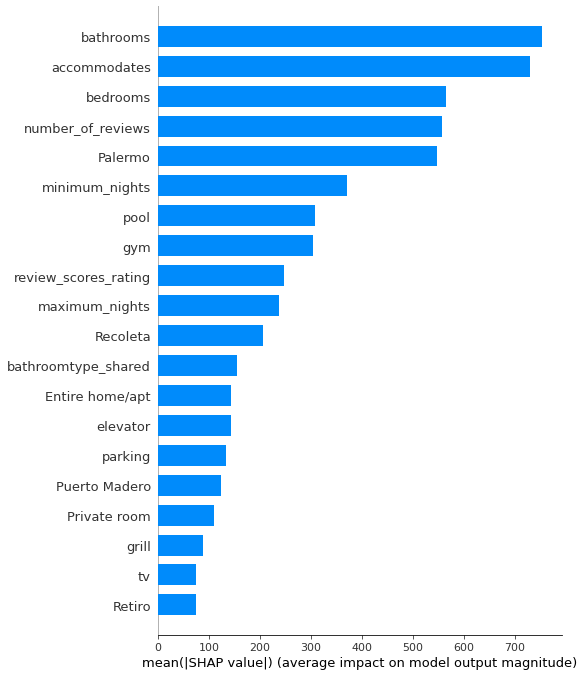

In [22]:
explainer = shap.TreeExplainer(models[5]["model"])
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)
shap.summary_plot(shap_values, X_test, plot_type='bar')

#### Gráficos Random Forest

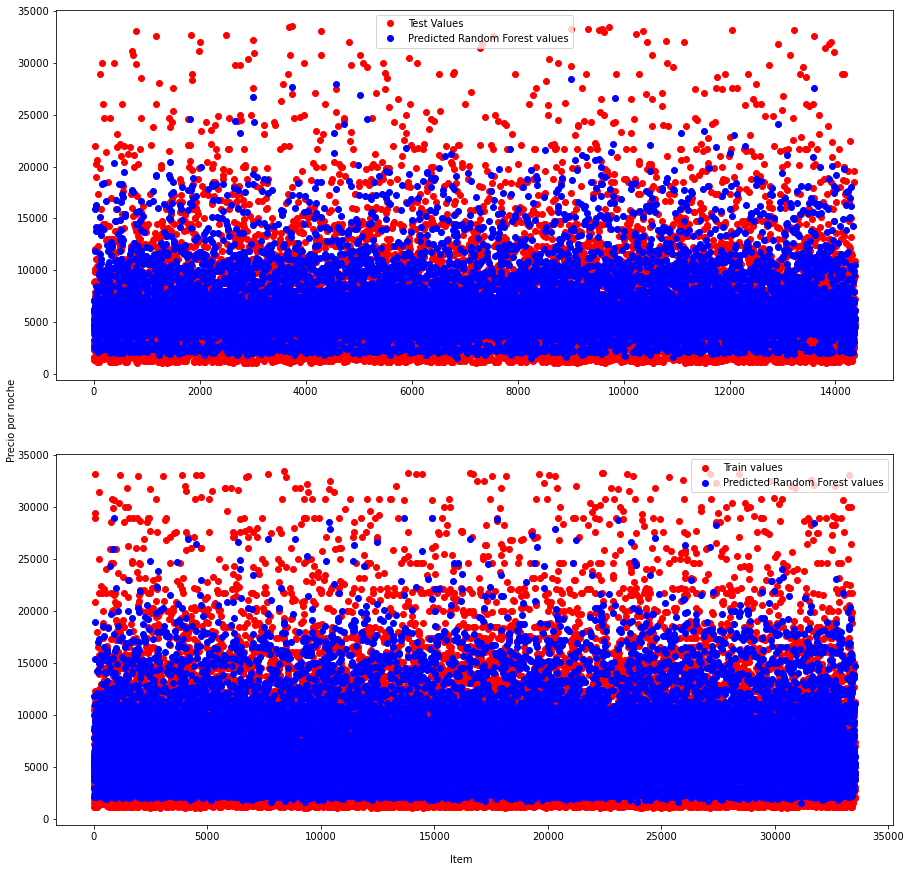

In [23]:
y_test_prediction = models[6]["model"].predict(X_test)
y_train_prediction = models[6]["model"].predict(X_train)
plot_train_test(y_test,y_test_prediction,y_train,y_train_prediction,models[6]["name"])

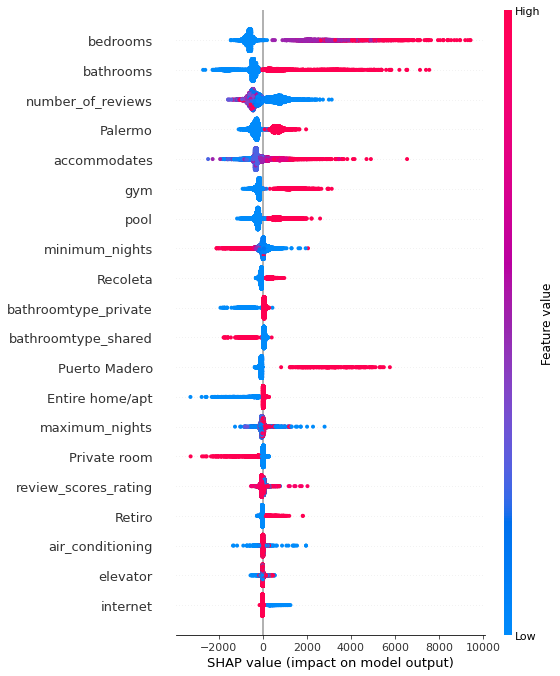

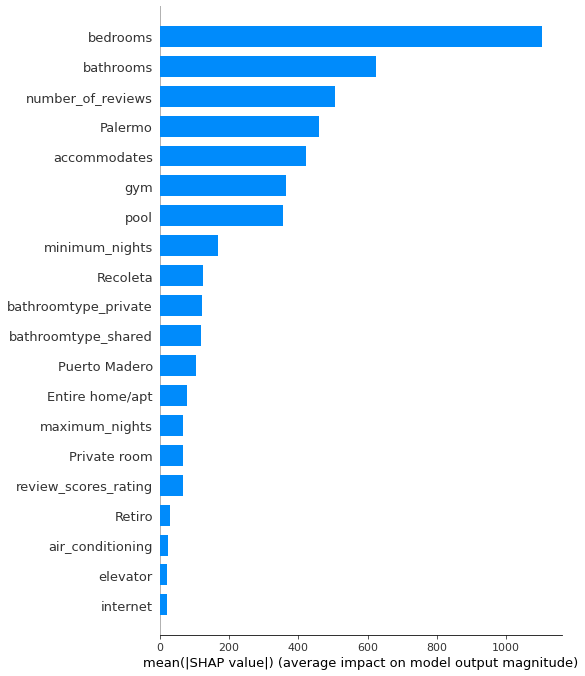

In [24]:
explainer = shap.TreeExplainer(models[6]["model"])
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)
shap.summary_plot(shap_values, X_test, plot_type='bar')

## Modelo

In [80]:
joblib.dump(models[3]["model"],'model2.sav')

['model2.sav']